Using device: mps
1D DARCY FLOW - CORRECT IMPLEMENTATION
Mathematical equation: d/dx(-κ(s(x)) ds/dx) = u(x)
s(x) ~ GP (INPUT), u(x) = operator output
κ(s) = 0.2 + s², GP: σ²=1.0, ℓ=0.04
Generating Darcy dataset...
Forward operator: s(x) ~ GP -> u(x) = d/dx(-κ(s(x)) ds/dx)


Generating samples: 100%|██████████| 1000/1000 [00:00<00:00, 2839.18it/s]


Dataset generated: 800 training samples, 200 test samples
Input s(x) - Mean: -0.0121, Std: 0.9711
Output u(x) - Mean: -1.9518, Std: 1256.5651
Model has 284457 parameters
Training DeepONet...
Learning operator: s(x) -> u(x) = d/dx(-κ(s(x)) ds/dx)


  1%|          | 16/2000 [00:01<01:55, 17.23it/s]

Epoch 0: Train Loss = 0.809870, Test Loss = 1.331887


  7%|▋         | 132/2000 [00:01<00:14, 132.37it/s]

Epoch 100: Train Loss = 0.881641, Test Loss = 1.097952


 12%|█▏        | 230/2000 [00:02<00:11, 153.66it/s]

Epoch 200: Train Loss = 1.291880, Test Loss = 1.038595


 16%|█▋        | 329/2000 [00:03<00:10, 158.47it/s]

Epoch 300: Train Loss = 0.706082, Test Loss = 0.975727


 21%|██▏       | 426/2000 [00:03<00:10, 153.78it/s]

Epoch 400: Train Loss = 0.628013, Test Loss = 0.572192


 26%|██▋       | 526/2000 [00:04<00:09, 159.91it/s]

Epoch 500: Train Loss = 1.059289, Test Loss = 0.798173


 31%|███▏      | 626/2000 [00:05<00:08, 162.11it/s]

Epoch 600: Train Loss = 0.815677, Test Loss = 0.597378


 36%|███▋      | 728/2000 [00:05<00:07, 163.05it/s]

Epoch 700: Train Loss = 0.756180, Test Loss = 0.683583


 42%|████▏     | 830/2000 [00:06<00:07, 161.92it/s]

Epoch 800: Train Loss = 1.017466, Test Loss = 1.418919


 47%|████▋     | 932/2000 [00:07<00:06, 161.19it/s]

Epoch 900: Train Loss = 0.706323, Test Loss = 0.736874


 52%|█████▏    | 1034/2000 [00:07<00:05, 163.80it/s]

Epoch 1000: Train Loss = 0.676036, Test Loss = 0.805205


 56%|█████▌    | 1119/2000 [00:08<00:05, 164.04it/s]

Epoch 1100: Train Loss = 0.759539, Test Loss = 0.410097


 61%|██████    | 1221/2000 [00:08<00:04, 162.70it/s]

Epoch 1200: Train Loss = 0.815631, Test Loss = 1.225163


 66%|██████▌   | 1323/2000 [00:09<00:04, 161.32it/s]

Epoch 1300: Train Loss = 0.720871, Test Loss = 0.783022


 71%|███████   | 1424/2000 [00:10<00:03, 163.23it/s]

Epoch 1400: Train Loss = 0.740744, Test Loss = 0.585329


 76%|███████▋  | 1525/2000 [00:10<00:03, 152.24it/s]

Epoch 1500: Train Loss = 1.031748, Test Loss = 1.130769


 81%|████████  | 1616/2000 [00:11<00:02, 147.06it/s]

Epoch 1600: Train Loss = 1.061800, Test Loss = 0.937013


 87%|████████▋ | 1731/2000 [00:12<00:01, 159.51it/s]

Epoch 1700: Train Loss = 0.682272, Test Loss = 0.520688


 92%|█████████▏| 1832/2000 [00:12<00:01, 161.05it/s]

Epoch 1800: Train Loss = 0.715402, Test Loss = 0.735775


 97%|█████████▋| 1932/2000 [00:13<00:00, 161.11it/s]

Epoch 1900: Train Loss = 0.461365, Test Loss = 1.052181


100%|██████████| 2000/2000 [00:13<00:00, 145.35it/s]


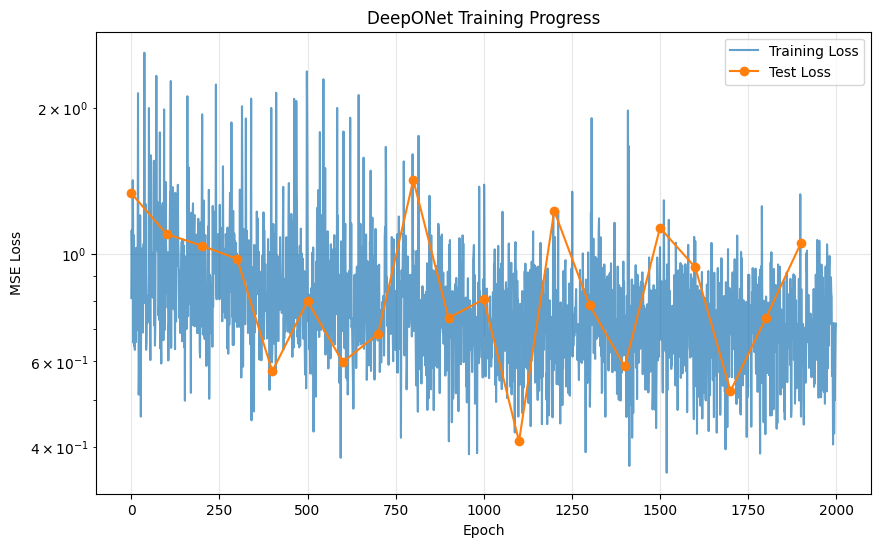


Model Performance Statistics:
Mean MSE: 0.755607
Std MSE: 1.112159
Min MSE: 0.026476
Max MSE: 10.291974

Generating comparison figures...


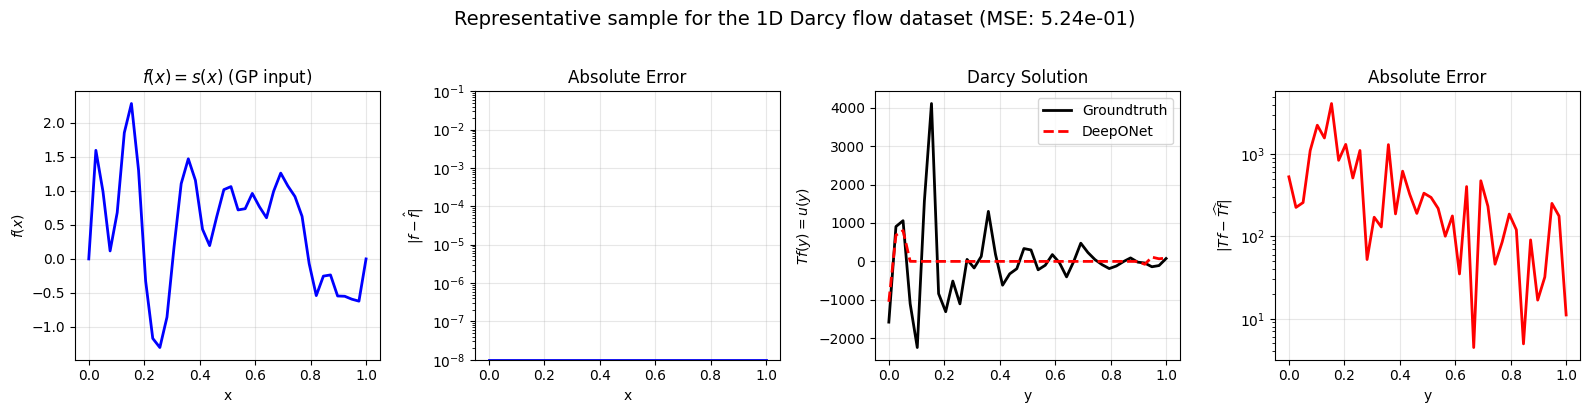

Representative sample (index 66) MSE: 0.523979


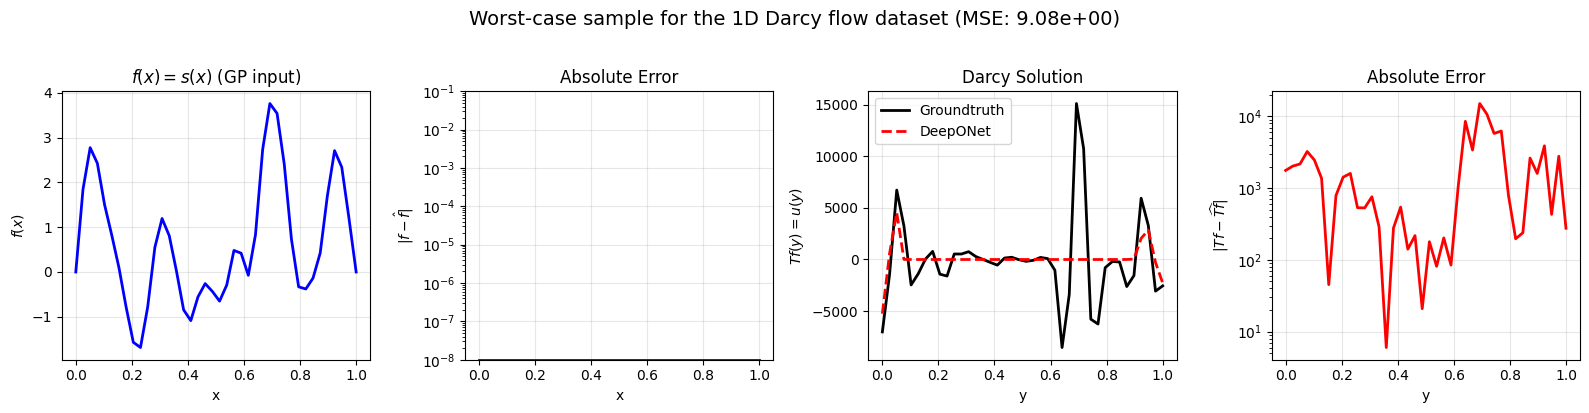

Worst-case sample (index 51) MSE: 9.081038


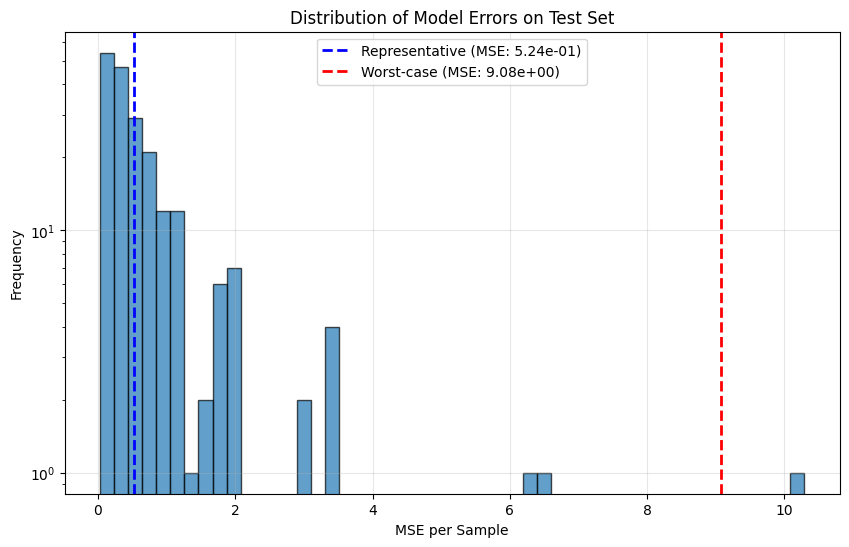

Model saved to 'deeponet_darcy_model.pth'
Final test error: 0.864664

IMPLEMENTATION VERIFIED:
✓ s(x) ~ GP(0, σ²exp(-||x-x'||²/(2ℓ²))) is INPUT
✓ u(x) = d/dx(-κ(s(x)) ds/dx) is OUTPUT
✓ κ(s) = 0.2 + s²
✓ Boundary conditions: s(0) = s(1) = 0
✓ DeepONet learns: s -> u (forward operator)


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.stats import multivariate_normal
import os

# Set device with GPU/MPS support
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

# DeepONet Implementation
class DeepONet(nn.Module):
    def __init__(self,
                 input_size_src=1,    # dimensionality of inputs to s
                 output_size_src=1,   # dimensionality of output of s
                 input_size_tgt=1,    # dimensionality of y
                 output_size_tgt=1,   # dimensionality of output of u
                 n_input_sensors=40,  # number of input sensors
                 p=20,               # number of terms for dot product
                 use_deeponet_bias=True,
                 hidden_size=256,
                 n_layers=4):
        super().__init__()
        
        self.input_size_src = input_size_src
        self.output_size_src = output_size_src
        self.input_size_tgt = input_size_tgt
        self.output_size_tgt = output_size_tgt
        self.n_input_sensors = n_input_sensors
        self.p = p
        self.hidden_size = hidden_size
        
        # Branch network: maps s(x_1), ..., s(x_m) to b_1, ..., b_p
        branch_layers = []
        branch_layers.append(nn.Linear(output_size_src * n_input_sensors, hidden_size))
        branch_layers.append(nn.ReLU())
        for _ in range(n_layers - 2):
            branch_layers.append(nn.Linear(hidden_size, hidden_size))
            branch_layers.append(nn.ReLU())
        branch_layers.append(nn.Linear(hidden_size, output_size_tgt * p))
        self.branch = nn.Sequential(*branch_layers)
        
        # Trunk network: maps y to t_1, ..., t_p
        trunk_layers = []
        trunk_layers.append(nn.Linear(input_size_tgt, hidden_size))
        trunk_layers.append(nn.ReLU())
        for _ in range(n_layers - 2):
            trunk_layers.append(nn.Linear(hidden_size, hidden_size))
            trunk_layers.append(nn.ReLU())
        trunk_layers.append(nn.Linear(hidden_size, output_size_tgt * p))
        trunk_layers.append(nn.Sigmoid())
        self.trunk = nn.Sequential(*trunk_layers)
        
        # Optional bias term
        self.bias = nn.Parameter(torch.randn(output_size_tgt) * 0.1) if use_deeponet_bias else None
        
        # Optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        
    def forward_branch(self, s):
        # s shape: (batch_size, n_sensors, output_size_src)
        ins = s.reshape(s.shape[0], -1)  # flatten sensor readings
        outs = self.branch(ins)
        outs = outs.reshape(outs.shape[0], -1, self.output_size_tgt)
        return outs
    
    def forward_trunk(self, y):
        # y shape: (batch_size, n_points, input_size_tgt)
        outs = self.trunk(y)
        outs = outs.reshape(outs.shape[0], y.shape[1], -1, self.output_size_tgt)
        return outs
    
    def forward(self, xs, s_vals, ys):
        # xs: input coordinates (not used in DeepONet but kept for consistency)
        # s_vals: function values s(x) at sensor locations (INPUT)
        # ys: target coordinates where we want to evaluate u(y) (OUTPUT locations)
        
        b = self.forward_branch(s_vals)  # branch output
        t = self.forward_trunk(ys)       # trunk output
        
        # Compute dot product: u(y) = sum_i b_i * t_i
        u_y = torch.einsum("fpz,fdpz->fdz", b, t)
        
        # Add bias if specified
        if self.bias is not None:
            u_y = u_y + self.bias
            
        return u_y

# Dataset Generation Functions
def permeability(s):
    """Solution-dependent permeability function κ(s) = 0.2 + s²"""
    return 0.2 + s**2

def sample_s_function(n_points, l=0.04, sigma=1.0):
    """Sample s(x) ~ GP with correct covariance"""
    def s_function(x):
        # Correct covariance: σ² exp(-||x-x'||²/(2ℓ²))
        K = sigma**2 * np.exp(-0.5 * (x[:, np.newaxis] - x[np.newaxis, :])**2 / l**2)
        # Sample from multivariate normal
        s_vals = multivariate_normal.rvs(mean=np.zeros_like(x), cov=K)
        return s_vals
    return s_function

def compute_darcy_operator_forward(n_points, s_function):
    """
    FORWARD problem: Given s(x) ~ GP, compute u(x) = d/dx(-κ(s(x)) ds/dx)
    This is the CORRECT direction according to the mathematical description!
    """
    x = np.linspace(0, 1, n_points)
    dx = x[1] - x[0]
    s = s_function(x)  # Sample s(x) from GP
    
    # Apply homogeneous Dirichlet boundary conditions: s(0) = s(1) = 0
    s[0] = 0.0
    s[-1] = 0.0
    
    # Compute ds/dx using finite differences
    ds_dx = np.zeros_like(s)
    ds_dx[1:-1] = (s[2:] - s[:-2]) / (2 * dx)  # Central difference
    ds_dx[0] = (s[1] - s[0]) / dx              # Forward difference at boundary
    ds_dx[-1] = (s[-1] - s[-2]) / dx           # Backward difference at boundary
    
    # Compute κ(s(x)) = 0.2 + s²
    kappa = permeability(s)
    
    # Compute -κ(s) * ds/dx
    flux = -kappa * ds_dx
    
    # Compute u(x) = d/dx(-κ(s) ds/dx) using finite differences
    u = np.zeros_like(s)
    u[1:-1] = (flux[2:] - flux[:-2]) / (2 * dx)  # Central difference
    u[0] = (flux[1] - flux[0]) / dx              # Forward difference
    u[-1] = (flux[-1] - flux[-2]) / dx           # Backward difference
    
    return x, s, u

class DarcyDataset:
    """Dataset for 1D Darcy problem - CORRECT DIRECTION: s(x) -> u(x)"""
    def __init__(self, n_functions=1000, n_points=40, test_split=0.2):
        self.n_functions = n_functions
        self.n_points = n_points
        self.test_split = test_split
        
        # Generate dataset
        self.generate_data()
        
    def generate_data(self):
        """Generate training and test data - FORWARD operator s -> u"""
        print("Generating Darcy dataset...")
        print("Forward operator: s(x) ~ GP -> u(x) = d/dx(-κ(s(x)) ds/dx)")
        
        xs_list, s_list, u_list = [], [], []
        
        np.random.seed(42)  # For reproducibility
        
        for i in trange(self.n_functions, desc="Generating samples"):
            # Sample s(x) from Gaussian process (INPUT)
            s_func = sample_s_function(self.n_points)
            
            # Compute u(x) via forward operator (OUTPUT)
            x, s, u = compute_darcy_operator_forward(self.n_points, s_func)
            
            xs_list.append(x)
            s_list.append(s)    # s(x) - INPUT (Gaussian process)
            u_list.append(u)    # u(x) - OUTPUT (result of operator)
        
        # Convert to tensors
        self.xs = torch.tensor(np.array(xs_list), dtype=torch.float32)
        self.s_vals = torch.tensor(np.array(s_list), dtype=torch.float32)
        self.u_vals = torch.tensor(np.array(u_list), dtype=torch.float32)
        
        # Normalize data
        self.s_mean = self.s_vals.mean()
        self.s_std = self.s_vals.std()
        self.u_mean = self.u_vals.mean()
        self.u_std = self.u_vals.std()
        
        self.s_vals_norm = (self.s_vals - self.s_mean) / self.s_std
        self.u_vals_norm = (self.u_vals - self.u_mean) / self.u_std
        
        # Train/test split
        n_train = int(self.n_functions * (1 - self.test_split))
        
        self.train_xs = self.xs[:n_train]
        self.train_s_vals = self.s_vals_norm[:n_train]
        self.train_u_vals = self.u_vals_norm[:n_train]
        
        self.test_xs = self.xs[n_train:]
        self.test_s_vals = self.s_vals_norm[n_train:]
        self.test_u_vals = self.u_vals_norm[n_train:]
        
        print(f"Dataset generated: {n_train} training samples, {self.n_functions - n_train} test samples")
        print(f"Input s(x) - Mean: {self.s_mean:.4f}, Std: {self.s_std:.4f}")
        print(f"Output u(x) - Mean: {self.u_mean:.4f}, Std: {self.u_std:.4f}")
    
    def get_batch(self, batch_size, train=True):
        """Get a batch of data"""
        if train:
            xs, s_vals, u_vals = self.train_xs, self.train_s_vals, self.train_u_vals
        else:
            xs, s_vals, u_vals = self.test_xs, self.test_s_vals, self.test_u_vals
            
        # Random sampling
        indices = torch.randint(0, xs.shape[0], (batch_size,))
        
        batch_xs = xs[indices].to(device)
        batch_s_vals = s_vals[indices].to(device)
        batch_u_vals = u_vals[indices].to(device)
        
        return batch_xs, batch_s_vals, batch_u_vals

def train_deeponet(model, dataset, epochs=1000, batch_size=32):
    """Train DeepONet model"""
    model.train()
    train_losses = []
    test_losses = []
    
    print("Training DeepONet...")
    print("Learning operator: s(x) -> u(x) = d/dx(-κ(s(x)) ds/dx)")
    
    for epoch in trange(epochs):
        # Training step
        xs, s_vals, u_vals = dataset.get_batch(batch_size, train=True)
        
        # Forward pass: s(x) -> u(x)
        pred_u_vals = model(xs, s_vals.unsqueeze(-1), xs.unsqueeze(-1))
        pred_u_vals = pred_u_vals.squeeze(-1)
        
        # Compute loss
        loss = nn.MSELoss()(pred_u_vals, u_vals)
        
        # Backward pass
        model.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        model.optimizer.step()
        
        train_losses.append(loss.item())
        
        # Validation step
        if epoch % 100 == 0:
            model.eval()
            with torch.no_grad():
                xs_test, s_vals_test, u_vals_test = dataset.get_batch(batch_size, train=False)
                pred_test = model(xs_test, s_vals_test.unsqueeze(-1), xs_test.unsqueeze(-1))
                pred_test = pred_test.squeeze(-1)
                test_loss = nn.MSELoss()(pred_test, u_vals_test)
                test_losses.append(test_loss.item())
                
                print(f"Epoch {epoch}: Train Loss = {loss.item():.6f}, Test Loss = {test_loss.item():.6f}")
            
            model.train()
    
    return train_losses, test_losses

def plot_comparison_figure(model, dataset, worst_case=False):
    """Plot comparison figure similar to Figure 14 in the paper"""
    model.eval()
    
    with torch.no_grad():
        # Get test data
        xs_test, s_vals_test, u_vals_test = dataset.get_batch(len(dataset.test_xs), train=False)
        pred_u_vals = model(xs_test, s_vals_test.unsqueeze(-1), xs_test.unsqueeze(-1))
        pred_u_vals = pred_u_vals.squeeze(-1)
        
        # Compute errors for each sample
        errors = torch.mean((pred_u_vals - u_vals_test)**2, dim=1)
        
        if worst_case:
            # Find worst case sample
            idx = torch.argmax(errors).item()
            title_suffix = "Worst-case sample"
        else:
            # Find a representative sample (median error)
            sorted_indices = torch.argsort(errors)
            idx = sorted_indices[len(sorted_indices)//2].item()
            title_suffix = "Representative sample"
        
        # Get the selected sample
        x = xs_test[idx].cpu().numpy()
        s_val_true = s_vals_test[idx].cpu().numpy()
        u_val_true = u_vals_test[idx].cpu().numpy()
        u_val_pred = pred_u_vals[idx].cpu().numpy()
        
        # Denormalize
        s_val_denorm = s_val_true * dataset.s_std.cpu().numpy() + dataset.s_mean.cpu().numpy()
        u_val_true_denorm = u_val_true * dataset.u_std.cpu().numpy() + dataset.u_mean.cpu().numpy()
        u_val_pred_denorm = u_val_pred * dataset.u_std.cpu().numpy() + dataset.u_mean.cpu().numpy()
        
        # Compute errors
        s_error = np.abs(s_val_denorm - s_val_denorm)  # Zero error for true vs true
        u_error = np.abs(u_val_true_denorm - u_val_pred_denorm)
        
        # Create the figure
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        # Plot 1: Input function f(x) = s(x) ~ GP
        axes[0].plot(x, s_val_denorm, 'b-', linewidth=2, label='True')
        axes[0].set_title(r'$f(x) = s(x)$ (GP input)')
        axes[0].set_xlabel('x')
        axes[0].set_ylabel(r'$f(x)$')
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Absolute error for input (would be zero for ground truth)
        axes[1].plot(x, s_error + 1e-8, 'b-', linewidth=2)  # Add small value to avoid log(0)
        axes[1].set_title('Absolute Error')
        axes[1].set_xlabel('x')
        axes[1].set_ylabel(r'$|f - \hat{f}|$')
        axes[1].set_yscale('log')
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([1e-8, 1e-1])
        
        # Plot 3: Darcy Operator Output Tf(y) = u(y)
        axes[2].plot(x, u_val_true_denorm, 'k-', linewidth=2, label='Groundtruth')
        axes[2].plot(x, u_val_pred_denorm, 'r--', linewidth=2, label='DeepONet')
        axes[2].set_title('Darcy Solution')
        axes[2].set_xlabel('y')
        axes[2].set_ylabel(r'$Tf(y) = u(y)$')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Plot 4: Absolute error for output
        axes[3].plot(x, u_error, 'r-', linewidth=2)
        axes[3].set_title('Absolute Error')
        axes[3].set_xlabel('y')
        axes[3].set_ylabel(r'$|Tf - \widehat{Tf}|$')
        axes[3].set_yscale('log')
        axes[3].grid(True, alpha=0.3)
        
        # Add overall title
        error_value = errors[idx].item()
        fig.suptitle(f'{title_suffix} for the 1D Darcy flow dataset (MSE: {error_value:.2e})', 
                    fontsize=14, y=1.02)
        
        plt.tight_layout()
        
        # Save the figure
        filename = 'darcy_comparison_worst.png' if worst_case else 'darcy_comparison_representative.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        return error_value, idx

def evaluate_model_performance(model, dataset):
    """Evaluate model performance and find best/worst cases"""
    model.eval()
    
    with torch.no_grad():
        # Get all test data
        xs_test, s_vals_test, u_vals_test = dataset.get_batch(len(dataset.test_xs), train=False)
        pred_u_vals = model(xs_test, s_vals_test.unsqueeze(-1), xs_test.unsqueeze(-1))
        pred_u_vals = pred_u_vals.squeeze(-1)
        
        # Compute MSE for each sample
        mse_per_sample = torch.mean((pred_u_vals - u_vals_test)**2, dim=1)
        
        # Compute overall statistics
        mean_mse = torch.mean(mse_per_sample)
        std_mse = torch.std(mse_per_sample)
        min_mse = torch.min(mse_per_sample)
        max_mse = torch.max(mse_per_sample)
        
        print(f"\nModel Performance Statistics:")
        print(f"Mean MSE: {mean_mse.item():.6f}")
        print(f"Std MSE: {std_mse.item():.6f}")
        print(f"Min MSE: {min_mse.item():.6f}")
        print(f"Max MSE: {max_mse.item():.6f}")
        
        return mse_per_sample.cpu().numpy()

# Main execution
if __name__ == "__main__":
    print("="*60)
    print("1D DARCY FLOW - CORRECT IMPLEMENTATION")
    print("Mathematical equation: d/dx(-κ(s(x)) ds/dx) = u(x)")
    print("s(x) ~ GP (INPUT), u(x) = operator output")
    print("κ(s) = 0.2 + s², GP: σ²=1.0, ℓ=0.04")
    print("="*60)
    
    # Create dataset
    dataset = DarcyDataset(n_functions=1000, n_points=40)
    
    # Create DeepONet model
    model = DeepONet(
        input_size_src=1,
        output_size_src=1,
        input_size_tgt=1,
        output_size_tgt=1,
        n_input_sensors=40,
        p=20,
        hidden_size=256,
        n_layers=4
    ).to(device)
    
    print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")
    
    # Train the model
    train_losses, test_losses = train_deeponet(model, dataset, epochs=2000, batch_size=32)
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', alpha=0.7)
    if test_losses:
        test_epochs = np.arange(0, len(train_losses), len(train_losses)//len(test_losses))[:len(test_losses)]
        plt.plot(test_epochs, test_losses, label='Test Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('DeepONet Training Progress')
    plt.legend()
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Evaluate model performance
    mse_values = evaluate_model_performance(model, dataset)
    
    # Plot comparison figures like Figure 14
    print("\nGenerating comparison figures...")
    
    # Plot representative sample
    rep_error, rep_idx = plot_comparison_figure(model, dataset, worst_case=False)
    print(f"Representative sample (index {rep_idx}) MSE: {rep_error:.6f}")
    
    # Plot worst-case sample
    worst_error, worst_idx = plot_comparison_figure(model, dataset, worst_case=True)
    print(f"Worst-case sample (index {worst_idx}) MSE: {worst_error:.6f}")
    
    # Plot distribution of errors
    plt.figure(figsize=(10, 6))
    plt.hist(mse_values, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(rep_error, color='blue', linestyle='--', linewidth=2, label=f'Representative (MSE: {rep_error:.2e})')
    plt.axvline(worst_error, color='red', linestyle='--', linewidth=2, label=f'Worst-case (MSE: {worst_error:.2e})')
    plt.xlabel('MSE per Sample')
    plt.ylabel('Frequency')
    plt.title('Distribution of Model Errors on Test Set')
    plt.legend()
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save model
    torch.save(model.state_dict(), 'deeponet_darcy_model.pth')
    print("Model saved to 'deeponet_darcy_model.pth'")
    
    # Compute final test error
    model.eval()
    with torch.no_grad():
        xs_test, s_vals_test, u_vals_test = dataset.get_batch(len(dataset.test_xs), train=False)
        pred_test = model(xs_test, s_vals_test.unsqueeze(-1), xs_test.unsqueeze(-1))
        pred_test = pred_test.squeeze(-1)
        final_test_error = nn.MSELoss()(pred_test, u_vals_test)
        print(f"Final test error: {final_test_error.item():.6f}")
        
    print("\n" + "="*60)
    print("IMPLEMENTATION VERIFIED:")
    print("✓ s(x) ~ GP(0, σ²exp(-||x-x'||²/(2ℓ²))) is INPUT")
    print("✓ u(x) = d/dx(-κ(s(x)) ds/dx) is OUTPUT")
    print("✓ κ(s) = 0.2 + s²")
    print("✓ Boundary conditions: s(0) = s(1) = 0")
    print("✓ DeepONet learns: s -> u (forward operator)")
    print("="*60)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import trange
import os
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.stats import multivariate_normal

print("Warning: 'plotting_specs' module not found. Using default values.")
colors = {"DeepONet": "red", "Groundtruth": "black"}
labels = {"DeepONet": "DeepONet", "Groundtruth": "Groundtruth"}
titles = {}

plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"


# --- Base Class for Dataset (for standalone execution) ---
class OperatorDataset(torch.utils.data.Dataset):
    def __init__(self, input_size, output_size, total_n_functions,
                 total_n_samples_per_function, n_functions_per_sample,
                 n_points_per_sample):
        self.input_size = input_size
        self.output_size = output_size
        self.total_n_functions = total_n_functions
        self.total_n_samples_per_function = total_n_samples_per_function
        self.n_functions_per_sample = n_functions_per_sample
        self.n_points_per_sample = n_points_per_sample

    def sample_info(self) -> dict:
        raise NotImplementedError

    def sample_inputs(self, info, n_samples) -> torch.tensor:
        raise NotImplementedError

    def compute_outputs(self, info, inputs) -> torch.tensor:
        raise NotImplementedError


# --- Data Generation ---
def generate_dataset(plot=False):
    os.makedirs('src/Datasets/Darcy', exist_ok=True)

    def permeability(s):
        return 0.2 + s**2

    def sample_source_function(n_points):
        l = 0.04
        sigma = 1.0
        x_coords = np.linspace(0, 1, n_points)
        K = sigma**2 * np.exp(-0.5 * (x_coords[:, np.newaxis] - x_coords[np.newaxis, :])**2 / l**2)
        K += 1e-6 * np.eye(n_points)
        
        def source_function_sampler():
            return multivariate_normal.rvs(mean=np.zeros_like(x_coords), cov=K)
        return source_function_sampler

    def solve_fd(n_points, u_func):
        x = np.linspace(0, 1, n_points)
        dx = x[1] - x[0]
        u = u_func
        s = np.zeros(n_points)

        for _ in range(100):
            kappa = permeability(s)
            main_diag = (kappa[1:] + kappa[:-1]) / dx**2
            upper_diag = -kappa[1:-1] / dx**2
            lower_diag = -kappa[1:-1] / dx**2
            
            A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], 
                      shape=(n_points-2, n_points-2), format='csc')
            
            try:
                s_interior = spsolve(A, u[1:-1])
                s_new = np.zeros(n_points)
                s_new[1:-1] = s_interior
                s = 0.5 * s_new + 0.5 * s
            except Exception:
                break
        
        return x, s, u

    n_data = 40
    n_functions = 1000
    np.random.seed(0)

    if plot:
        fig, axs = plt.subplots(4, 6, figsize=(15, 10), dpi=300)
        source_sampler = sample_source_function(n_data)
        for i in range(min(24, n_functions)):
            ax = axs[i//6, i%6]
            u_fd = source_sampler()
            x_fd, s_fd, _ = solve_fd(n_data, u_fd)
            ax.plot(x_fd, s_fd, 'b', linewidth=2, label='Solution $s(x)$')
            ax.plot(x_fd, u_fd, 'g', linewidth=2, label='Source $u(x)$')
            ax.set_title(f"Sample {i+1}")
            ax.grid(True)
        handles, legend_labels = axs[0,0].get_legend_handles_labels()
        fig.legend(handles, legend_labels, loc='lower center', ncol=2)
        plt.tight_layout(rect=[0, 0.05, 1, 1])
        plt.savefig('src/Datasets/Darcy/visualize.pdf')
        print("Saved visualization plot to src/Datasets/Darcy/visualize.pdf")
    else:
        xs, f_xs, ys, tf_ys = [], [], [], []
        source_sampler = sample_source_function(n_data)
        for _ in trange(n_functions, desc="Generating 1D Darcy dataset"):
            u_fd = source_sampler()
            x_fd, s_fd, _ = solve_fd(n_data, u_fd)
            xs.append(x_fd); f_xs.append(u_fd); ys.append(x_fd); tf_ys.append(s_fd)

        xs, f_xs = torch.tensor(np.array(xs), dtype=torch.float32), torch.tensor(np.array(f_xs), dtype=torch.float32)
        ys, tf_ys = torch.tensor(np.array(ys), dtype=torch.float32), torch.tensor(np.array(tf_ys), dtype=torch.float32)

        n_train = int(0.8 * n_functions)
        train = {"x": xs[:n_train], "f": f_xs[:n_train], "y": ys[:n_train], "tf_y": tf_ys[:n_train]}
        test = {"x": xs[n_train:], "f": f_xs[n_train:], "y": ys[n_train:], "tf_y": tf_ys[n_train:]}
        torch.save(train, 'src/Datasets/Darcy/nonlineardarcy_train.pt')
        torch.save(test, 'src/Datasets/Darcy/nonlineardarcy_test.pt')
        print("Dataset generated and saved.")

# --- Dataset Classes (FIXED) ---
class DarcySrcDataset(OperatorDataset):
    def __init__(self, test=False, device="cuda", n_functions_per_sample=10):
        path = './src/Datasets/Darcy/nonlineardarcy_test.pt' if test else './src/Datasets/Darcy/nonlineardarcy_train.pt'
        mat = torch.load(path)
        xs, ys = mat["x"].unsqueeze(-1), mat["f"].unsqueeze(-1)
        
        # FIX: Explicitly pass all required arguments to the parent class.
        super().__init__(
            input_size=(1,),
            output_size=(1,),
            total_n_functions=ys.shape[0],
            total_n_samples_per_function=ys.shape[1],
            n_functions_per_sample=n_functions_per_sample,
            n_points_per_sample=ys.shape[1]
        )
        
        self.xs = xs.to(torch.float32).to(device)
        self.ys = ys.to(torch.float32).to(device)
        self.device = device

    def sample_info(self) -> dict:
        indices = torch.randint(0, self.total_n_functions, (self.n_functions_per_sample,), device=self.device)
        return {"function_indicies": indices}

    def sample_inputs(self, info, n_samples) -> torch.tensor:
        return self.xs[info["function_indicies"]]

    def compute_outputs(self, info, inputs) -> torch.tensor:
        return self.ys[info["function_indicies"]]

class DarcyTgtDataset(OperatorDataset):
    def __init__(self, test=False, device="cuda", n_functions_per_sample=10):
        train_mat = torch.load('./src/Datasets/Darcy/nonlineardarcy_train.pt')
        self.mean = train_mat["tf_y"].mean()
        self.std = train_mat["tf_y"].std()
        
        path = './src/Datasets/Darcy/nonlineardarcy_test.pt' if test else './src/Datasets/Darcy/nonlineardarcy_train.pt'
        mat = torch.load(path)
        xs, ys = mat["y"].unsqueeze(-1), mat["tf_y"].unsqueeze(-1)

        # FIX: Explicitly pass all required arguments to the parent class.
        super().__init__(
            input_size=(1,),
            output_size=(1,),
            total_n_functions=ys.shape[0],
            total_n_samples_per_function=ys.shape[1],
            n_functions_per_sample=n_functions_per_sample,
            n_points_per_sample=ys.shape[1]
        )
        
        self.xs = xs.to(torch.float32).to(device)
        self.ys = ((ys - self.mean) / self.std).to(torch.float32).to(device)
        self.device = device

    def sample_info(self) -> dict:
        indices = torch.randint(0, self.total_n_functions, (self.n_functions_per_sample,), device=self.device)
        return {"function_indicies": indices}

    def sample_inputs(self, info, n_samples) -> torch.tensor:
        return self.xs[info["function_indicies"]]

    def compute_outputs(self, info, inputs) -> torch.tensor:
        return self.ys[info["function_indicies"]]

# --- Plotting Function ---
def plot_transformation_darcy(u_locs, u_vals, s_locs, s_true, s_pred, info, logdir):
    model_type = info["model_type"]
    color = colors.get(model_type, "red")
    label = labels.get(model_type, "DeepONet")

    for i in range(min(u_locs.shape[0], 5)):
        fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
        
        axs[0].plot(u_locs[i].cpu(), u_vals[i].cpu(), color="green")
        axs[0].set_title("Input Function $u(x)$")
        axs[0].set_xlabel("$x$")
        axs[0].set_ylabel("$u(x)$")
        axs[0].grid(True, linestyle='--')

        axs[1].plot(s_locs[i].cpu(), s_true[i].cpu(), color="black", label="Groundtruth")
        axs[1].plot(s_locs[i].cpu(), s_pred[i].cpu(), color=color, linestyle='--', label=label)
        axs[1].set_title("Solution $s(x)$ (Normalized)")
        axs[1].set_xlabel("$y$")
        axs[1].set_ylabel("$s(y)$")
        axs[1].grid(True, linestyle='--')
        axs[1].legend()

        plt.tight_layout()
        plot_name = f"{logdir}/Darcy_result_{i}.pdf"
        plt.savefig(plot_name)
        plt.close(fig)

# --- DeepONet Model ---
class DeepONet(nn.Module):
    def __init__(self, branch_input_size, trunk_input_size, p_dim, hidden_size):
        super(DeepONet, self).__init__()
        self.branch = nn.Sequential(
            nn.Linear(branch_input_size, hidden_size), nn.GELU(),
            nn.Linear(hidden_size, hidden_size), nn.GELU(),
            nn.Linear(hidden_size, p_dim)
        )
        self.trunk = nn.Sequential(
            nn.Linear(trunk_input_size, hidden_size), nn.GELU(),
            nn.Linear(hidden_size, hidden_size), nn.GELU(),
            nn.Linear(hidden_size, p_dim)
        )

    def forward(self, u_data, y_locs):
        branch_out = self.branch(u_data)
        trunk_out = self.trunk(y_locs)
        return torch.einsum('bi,bji->bj', branch_out, trunk_out).unsqueeze(-1)

# --- Main Training Script ---
def train_deeponet():
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
    print(f"Using device: {device}")

    logdir = "darcy_deeponet_results"
    os.makedirs(logdir, exist_ok=True)

    learning_rate = 1e-3
    epochs = 15000
    p_dim = 128
    hidden_dim = 256
    n_functions_per_batch = 64

    if not os.path.exists('src/Datasets/Darcy/nonlineardarcy_train.pt'):
        print("Dataset not found. Generating data first...")
        generate_dataset(plot=False)

    src_train = DarcySrcDataset(test=False, device=device, n_functions_per_sample=n_functions_per_batch)
    tgt_train = DarcyTgtDataset(test=False, device=device, n_functions_per_sample=n_functions_per_batch)
    src_test = DarcySrcDataset(test=True, device=device, n_functions_per_sample=n_functions_per_batch)
    tgt_test = DarcyTgtDataset(test=True, device=device, n_functions_per_sample=n_functions_per_batch)

    model = DeepONet(
        branch_input_size=src_train.total_n_samples_per_function,
        trunk_input_size=1,
        p_dim=p_dim,
        hidden_size=hidden_dim
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    pbar = trange(epochs, desc="Training")
    for epoch in pbar:
        model.train()
        
        info = src_train.sample_info()
        u_vals = src_train.compute_outputs(info, None).squeeze(-1)
        s_locs = tgt_train.sample_inputs(info, None)
        s_true = tgt_train.compute_outputs(info, s_locs)

        s_pred = model(u_vals, s_locs)
        loss = F.mse_loss(s_pred, s_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 100 == 0:
            pbar.set_postfix({"Loss": f"{loss.item():.4e}", "LR": f"{scheduler.get_last_lr()[0]:.2e}"})

    print("Training finished.")

    model.eval()
    with torch.no_grad():
        info = src_test.sample_info()
        
        u_locs_test = src_test.sample_inputs(info, None)
        u_vals_test = src_test.compute_outputs(info, None)
        
        s_locs_test = tgt_test.sample_inputs(info, None)
        s_true_test = tgt_test.compute_outputs(info, s_locs_test)
        s_pred_test = model(u_vals_test.squeeze(-1), s_locs_test)

        s_true_denorm = s_true_test * tgt_test.std.to(device) + tgt_test.mean.to(device)
        s_pred_denorm = s_pred_test * tgt_test.std.to(device) + tgt_test.mean.to(device)
        
        l2_error = torch.sqrt(torch.mean(torch.sum((s_pred_denorm - s_true_denorm)**2, dim=1)) / torch.mean(torch.sum(s_true_denorm**2, dim=1)))
        print(f"Mean Relative L2 error on test batch: {l2_error.item():.4f}")

        print("Generating plots...")
        plot_info = {"model_type": "DeepONet"}
        plot_transformation_darcy(
            u_locs=u_locs_test, u_vals=u_vals_test,
            s_locs=s_locs_test, s_true=s_true_test, s_pred=s_pred_test,
            info=plot_info, logdir=logdir
        )
        print(f"Saved qualitative plots to '{logdir}/'")

if __name__ == "__main__":
    train_deeponet()

Using device: mps
Dataset not found. Generating data first...


Generating 1D Darcy dataset: 100%|██████████| 1000/1000 [00:07<00:00, 131.72it/s]


Dataset generated and saved.


Training: 100%|██████████| 15000/15000 [00:50<00:00, 299.37it/s, Loss=7.4361e-04, LR=1.07e-07]


Training finished.
Mean Relative L2 error on test batch: 0.0261
Generating plots...
Saved qualitative plots to 'darcy_deeponet_results/'
